#### IMPORTING LIBRARYS


In [2]:
import time 
start=time.time()
import pandas as pd 
import numpy as np 
import seaborn as sns  
import nltk 
from nltk  import FreqDist,pos_tag
from random import randint 
#nltk.download('stopwords')
from nltk.corpus import stopwords,wordnet
import matplotlib.pyplot as plt  
from wordcloud import STOPWORDS,WordCloud  
from matplotlib import rcParams
from nltk.tokenize import sent_tokenize, word_tokenize  
from nltk.stem.snowball import SnowballStemmer  
from nltk.stem import WordNetLemmatizer   
import spacy
from spacy import displacy  
from statistics import mode 
import  string as String  
from sklearn.datasets import load_linnerud
from sklearn.model_selection import cross_val_predict,cross_val_score,train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression 
from sklearn.datasets import load_diabetes 
from sklearn.decomposition import PCA  
from sklearn.tree import  DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.neighbors import RadiusNeighborsRegressor 
from sklearn.cross_decomposition import PLSCanonical,PLSRegression
from sklearn.ensemble import ExtraTreesRegressor 
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import VotingRegressor  
from sklearn.multioutput import MultiOutputRegressor,MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.metrics import r2_score,confusion_matrix,ConfusionMatrixDisplay 
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from tqdm import tqdm 
import re as re 
import math  
import json

In [3]:
df_relevant=pd.read_csv("./newcsvs/relevant.csv")

#### LOADING AND PREPARING DATA

In [4]:

df_train=pd.read_csv("./data/train.csv") 
df_essays=pd.DataFrame(df_train["full_text"])
df_test=pd.read_csv("./data/test.csv")   
y=df_train.drop(["text_id","full_text"],axis=1)  
essays=df_essays["full_text"]
essays=list(essays) 
essays=" ".join(essays)  
essays=('''"""''') +essays + ('''"""''')   
target_names=list(y)
df_train

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5
...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5


## GLOBAL FUNCTIONS

In [5]:
english_words=[] 
file=open("./data/actual_all_words.txt","r")  
wfile=file.readlines() 
for word in wfile: 
    english_words.append(word.lower()) 
for i in range(0,len(english_words)):  
    english_words[i]=english_words[i].replace("\n","")    
NER = spacy.load("en_core_web_sm")     

In [79]:
unwanted_list=["'s","`s","´s","'re","`re","´re","n't","n´t","n`t","'ll","´ll","`ll","'d","´d","`d","'ve","`ve","´ve","'m","`m","´m","'",'"',".",",","`","!","?","´",':',"(",")","/",";",'#']
unwanted_list.extend(list(String.punctuation)) 
unwanted_list=list(set(unwanted_list))
stop_words=stopwords.words("english")     
load_model = spacy.load('en_core_web_sm', disable = ['parser','ner']) 
load_model.max_length =len(essays) *2
def remove_unwanted(string,unwanted):  
    for i in unwanted:  
        if i == "'s" or i== '`s' or i == '´s':   
            if "let's" in string or "let´s" in string or "let`s" in string:
                string=string.replace("let's","lets")
                string=string.replace("let´s","lets")
                string=string.replace("let`s","lets")
            string=string.replace(i," is") 
        elif i == "'re" or i== '`re' or i == '´re': 
            string=string.replace(i," are") 
        elif i== "n't" or i == "n`t" or i== "n´t":  
            if "won't" in string or "won´t" in string or "won`t" in string:
                string=string.replace("won`t","wont")
                string=string.replace("won´t","wont")
                string=string.replace("won't","wont")
            string=string.replace(i," will not")   
        elif i == "'ll" or i == "´ll" or i == "`ll": 
            string=string.replace(i," will") 
        elif i == "'d" or i == "´d" or i == "`d": 
            string=string.replace(i," would")
        elif i == "'ve" or i == "´ve" or i == "`ve": 
            string=string.replace(i," have") 
        elif i == "'m" or i == "´m" or i == "`m": 
            string=string.replace(i," am") 
        else:
            string=string.replace(i," ")
    return string    
def filter_text(string,stop_words=stop_words,unique_words=False,filter_by_sw=True,remove_numbers=False,remove_numbers_and_words_glued=False): 
    string=remove_unwanted(string,unwanted_list)  
    if remove_numbers: 
        string=removing_numbers(string) 
    if remove_numbers_and_words_glued: 
        string=removing_numbers(string,remove_text_next_to_num=True)
    tokenized=word_tokenize(string) 
    filtered=tuple(tokenized)
    if filter_by_sw:
        filtered=tuple([word.casefold() for word in tokenized if word.casefold() not in stop_words])
    if unique_words:
        filtered =tuple(set(filtered))
    return filtered 
def get_num_words(string,unique_words=True,filter_by_sw=True):  
    filtered=filter_text(string,unique_words=unique_words,filter_by_sw=filter_by_sw)
    return len(filtered)
def makeWordcloud(text,stopwords=STOPWORDS,maxwords=300,width=800,height=800,color="black",column="fulltext"): 
    if isinstance(text,pd.core.frame.DataFrame):  
        newtext="\n".join(text[column])
        wordcloud= WordCloud(width=width,height=height,stopwords=stopwords,background_color=color,max_words=maxwords).generate(text) 
        plt.figure(figsize=(20,15))  
        plt.clf()
        plt.imshow(wordcloud)
        plt.axis("off")  
        return plt.show()  
    elif isinstance(text,str):  
        wordcloud= WordCloud(width=width,height=height,stopwords=stopwords,background_color=color,max_words=maxwords).generate(text) 
        plt.figure(figsize=(20,15))  
        plt.clf()
        plt.imshow(wordcloud)
        plt.axis("off")  
        return plt.show()
    elif isinstance(text,list) or isinstance(text,np.ndarray) or isinstance(text,pd.core.series.Series): 
        newtext=" ".join(text)
        wordcloud= WordCloud(width=width,height=height,stopwords=stopwords,background_color=color,max_words=maxwords).generate(text) 
        plt.figure(figsize=(20,15))  
        plt.clf()
        plt.imshow(wordcloud)
        plt.axis("off")  
        return plt.show()  
def create_txt_with_example(specific=randint(0,len(df_train["full_text"]))): 
    newExample=open("./examples/example_%d.txt" % specific,"w") 
    newExample.write(df_train["full_text"][specific]) 
    newExample.close()  
def getcommonwords(text,amount=10):  
    filtered=filter_text(text,unique_words=False) 
    freq=FreqDist(filtered) 
    return tuple([word[0] for word in freq.most_common(amount)]) 
def pos_tag_text(text,filter=False,to_dic=False): 
    tagged=pos_tag(text) 
    return tagged
def mistakeCounter(essay): 
    filtered_text=filter_text(essay,filter_by_sw=False,unique_words=False)  
    a=[]
    for word in filtered_text: 
        if word.lower() not in english_words:  
           a.append(word)   
    NerText=NER(" ".join(a)) 
    for word in NerText.ents: 
        if word.label_ == "PERSON" or word.label_ == "ORG" or word.label_ == "LOC" or word.label_ == "DATE" or word.label_ == "MONEY"   or word.label_ == "PRODUCT" or word.label_ == "WORK_OF_ART" or word.label_ == "FAC" or word.label_ == "EVENT" or word.label_ == "GPE" or  word.label_ == "TIME" or  word.label_ == "PERCENT" or word.label_ == "NORP" :
            words=word_tokenize(word.text) 
            for j in words:  
                if j in a:
                    a.remove(j)
    final=a 
    return len(final)   
def mistakelist(essay):  
    filtered_text=filter_text(essay,filter_by_sw=False,unique_words=False)  
    a=[]
    for word in filtered_text: 
        if word.lower() not in english_words:  
           a.append(word)   
    NerText=NER(" ".join(a)) 
    for word in NerText.ents: 
        if word.label_ == "PERSON" or word.label_ == "ORG" or word.label_ == "LOC" or word.label_ == "DATE" or word.label_ == "MONEY"   or word.label_ == "PRODUCT" or word.label_ == "WORK_OF_ART" or word.label_ == "FAC" or word.label_ == "EVENT" or word.label_ == "GPE" or  word.label_ == "TIME" or  word.label_ == "PERCENT" or word.label_ == "NORP" :
            words=word_tokenize(word.text) 
            for j in words:  
                if j in a:
                    a.remove(j)
    final=a 
    return final 
def getradicals(essay): 
    doc=load_model(" ".join(filter_text(essay,unique_words=False))) 
    radicals=[token.lemma_ for token in doc] 
    final=radicals
    for word in radicals:
        if word not in english_words:
            if word in final: 
                final.remove(word)
    return final  
def amountRadicals(essay): 
    radicals=set(getradicals(essay))
    return len(radicals) 
def stop_words_counter(essay): 
    filtered=filter_text(essay,unique_words=False,filter_by_sw=False)  
    a=[]
    for word in filtered: 
        if word.lower() in stop_words: 
            a.append(word.lower()) 
    return len(a);  
def transform_to_bag_of_words(essay): 
    vectorizer=CountVectorizer(tokenizer=lambda text : filter_text(text,unique_words=False,filter_by_sw=True,remove_numbers_and_words_glued=True),stop_words=stop_words,max_features=6000) 
    if isinstance(essay,pd.core.frame.DataFrame)or isinstance(essay,pd.core.series.Series) :   
        bag=vectorizer.fit_transform(essay["full_text"]).toarray() 
        colnames=df_relevant.iloc[:,8:].columns
        new_cols=essay.loc[:,colnames].copy() 
        for i in colnames:  
            if i != "most_common_words":
                bag=np.c_[bag,essay[i]]
        return bag,vectorizer.get_feature_names_out()
    elif isinstance(essay,list):
        bag=vectorizer.fit_transform(essay).toarray() 
        return bag,vectorizer.get_feature_names_out()
    else: 
        bag=vectorizer.fit_transform([essay]).toarray()
        return bag,vectorizer.get_feature_names_out()  
def transform_totfidf(essay): 
    vectorizer=TfidfVectorizer(tokenizer=lambda text : filter_text(text,unique_words=False,filter_by_sw=True,remove_numbers_and_words_glued=True),stop_words=stop_words,max_features=6000) 
    if isinstance(essay,pd.core.frame.DataFrame)or isinstance(essay,pd.core.series.Series) :   
        idf=vectorizer.fit_transform(essay["full_text"]).toarray() 
        colnames=df_relevant.iloc[:,8:].columns
        new_cols=essay.loc[:,colnames].copy() 
        for i in colnames:  
            if i != "most_common_words":
                idf=np.c_[idf,essay[i]]
        return idf,vectorizer.get_feature_names_out()
    elif isinstance(essay,list):
        idf=vectorizer.fit_transform(essay).toarray() 
        return idf,vectorizer.get_feature_names_out()
    else: 
        idf=vectorizer.fit_transform([essay]).toarray()
        return idf,vectorizer.get_feature_names_out()  
def removing_numbers(essay,remove_text_next_to_num=False): 
    newessay=""
    if(remove_text_next_to_num): 
        newessay=re.sub(r"\d\w* | [\s]+ |\d+" ,"",essay) 
    else:
        newessay=re.sub(r"\d*" ,"",essay) 
    return newessay 
def padronizingpred(num): 
    if num < 1.0 or num > 5.0: 
        if num < 1: 
            return 1.0 
        else: 
            return 5.0  
    numfloor=float(math.floor(num))
    numceil=float(math.ceil(num))
    halfway=numceil-0.5  
    if num >= halfway :
        subhalfway=halfway+0.25 
        if num > subhalfway: 
            return numceil 
        else: 
            return halfway
    else: 
        subhalfway=halfway-0.25
        if num > subhalfway: 
            return halfway
        else: 
            return numfloor


In [81]:
randarr=np.random.uniform(1.0,5.0,100) 
randarrfixed=[padronizingpred(i) for i in randarr] 
a=list(zip(randarr,randarrfixed))
df_testing=pd.DataFrame(a,columns=['original','fixed'])   
df_testing

,original,fixed
0,3.871881,4.0
1,1.399742,1.5
2,1.347684,1.5
3,1.702970,1.5
4,1.548795,1.5
...,...,...
95,2.061379,2.0
96,3.309400,3.5
97,4.629906,4.5
98,1.508417,1.5


In [8]:
names={}
for i in range(0,len(target_names)):
    names[target_names[i]]=df_train[target_names][target_names[i]].value_counts() 
names

{'cohesion': 3.0    1096
 3.5     988
 2.5     790
 4.0     534
 2.0     315
 4.5     125
 1.5      27
 5.0      26
 1.0      10
 Name: cohesion, dtype: int64,
 'syntax': 3.0    1250
 3.5     867
 2.5     839
 2.0     410
 4.0     388
 4.5     100
 1.5      29
 5.0      17
 1.0      11
 Name: syntax, dtype: int64,
 'vocabulary': 3.0    1503
 3.5    1007
 4.0     577
 2.5     528
 2.0     124
 4.5     115
 5.0      41
 1.5      14
 1.0       2
 Name: vocabulary, dtype: int64,
 'phraseology': 3.0    1153
 3.5     929
 2.5     772
 4.0     553
 2.0     350
 4.5     108
 5.0      25
 1.5      11
 1.0      10
 Name: phraseology, dtype: int64,
 'grammar': 3.0    994
 3.5    880
 2.5    855
 2.0    544
 4.0    447
 4.5    134
 5.0     29
 1.5     20
 1.0      8
 Name: grammar, dtype: int64,
 'conventions': 3.0    1151
 3.5     908
 2.5     784
 4.0     484
 2.0     402
 4.5     122
 5.0      25
 1.5      20
 1.0      15
 Name: conventions, dtype: int64}

## CREATE AN EXAMPLE txt

In [9]:
#create_txt_with_example()   

## ADDING RELEVANT INFORMATION

### MAKING RELEVANT FILE

In [10]:
#df_relevant=df_train   
#df_relevant=pd.read_csv("./relevant/relevant.csv")

### guide to pos_tag

In [11]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

### GUIDE TO NER

In [12]:
NER.get_pipe('ner').labels  

('CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART')

### ADDING NUMBER OF WORDS PER ESSAY

In [13]:
""" df_train["full_text"]
e_string=df_essays["full_text"][300]
df_relevant["n_of_words"]=[get_num_words(essay,unique_words=False) for essay in df_train["full_text"]] 
df_relevant """

' df_train["full_text"]\ne_string=df_essays["full_text"][300]\ndf_relevant["n_of_words"]=[get_num_words(essay,unique_words=False) for essay in df_train["full_text"]] \ndf_relevant '

### ADDING 10 MOST COMMON WORDS OF EACH ESSAY

In [14]:
""" df_relevant["most_common_words"]=[getcommonwords(essay,10) for essay in df_essays["full_text"]]  
df_relevant """

' df_relevant["most_common_words"]=[getcommonwords(essay,10) for essay in df_essays["full_text"]]  \ndf_relevant '

### ADDING HOW MANY ORTOGRAPHY ERRORS

In [15]:
""" df_relevant["ort_mistakes"]=[mistakeCounter(essay) for essay in df_train["full_text"]] 
df_relevant      """

' df_relevant["ort_mistakes"]=[mistakeCounter(essay) for essay in df_train["full_text"]] \ndf_relevant      '

### GETTING RADICALS

In [16]:
""" df_relevant["amt_radicals"]=[amountRadicals(essay) for essay in df_train["full_text"]] 
df_relevant """

' df_relevant["amt_radicals"]=[amountRadicals(essay) for essay in df_train["full_text"]] \ndf_relevant '

### ADDING NUM OF STOPWORDS

In [17]:
""" df_relevant["amt_stopwords"]=[stop_words_counter(essay) for essay in df_train["full_text"]] 
df_relevant """

' df_relevant["amt_stopwords"]=[stop_words_counter(essay) for essay in df_train["full_text"]] \ndf_relevant '

## TESTING

creating sample df

In [18]:
asdasd=list(df_relevant.iloc[:,8:].columns) 
asdasd

['n_of_words',
 'most_common_words',
 'ort_mistakes',
 'amt_radicals',
 'amt_stopwords']

In [19]:
df_sample=df_relevant.sample(frac=0.2) 
df_sample

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,n_of_words,most_common_words,ort_mistakes,amt_radicals,amt_stopwords
2808,CD47F64F2398,The benefits of working with a group and why y...,2.5,3.0,3.0,3.0,2.0,2.5,188,"('group', 'complete', 'everyone', 'work', 'lie...",0,77,239
477,24050FFA49AE,I think cell phones gives negative effects on ...,3.0,3.0,3.5,3.5,4.0,3.0,208,"('people', 'technology', 'think', 'use', 'day'...",7,84,208
3602,F3259CFA6566,Being yourself brings out the better you in a ...,5.0,4.0,4.5,4.5,4.0,4.0,389,"('person', 'change', 'someone', 'one', 'people...",0,148,642
3347,E7A76C48340D,I think this council is debating the adoption....,2.5,2.0,3.0,2.0,2.0,2.0,247,"('people', 'someone', 'safe', 'street', 'make'...",0,120,343
417,1FB89CF59E5B,"Influence can be divided in words, actions, an...",3.5,3.5,3.5,3.5,3.5,4.0,296,"('influence', 'people', 'motivation', 'example...",8,101,316
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1606,7A68E1FB7863,Imagine an aboard student come from different ...,4.0,3.5,4.0,3.5,3.0,4.0,257,"('break', 'students', 'summer', 'time', 'long'...",3,121,269
1861,8C34447FF21C,I have heard that many people gets bully by ot...,2.0,2.0,2.5,2.0,2.5,2.5,120,"('people', 'bulling', 'bullied', 'thats', 'bad...",0,48,177
1987,9653A4188D80,I think we choose our character traits and we ...,3.0,3.5,3.0,3.0,4.0,3.5,139,"('think', 'people', 'choose', 'character', 'tr...",0,58,261
2932,D325C8F858F6,A group of students have skill to take decisio...,2.5,2.0,3.0,2.5,2.5,3.5,193,"('work', 'students', 'alone', 'groups', 'share...",1,100,193


saving sample data on disk

In [20]:
names={}
for i in target_names:  
    names[i]=df_sample[i].value_counts().sort_index()
try:
    nsampletdata=open("notes_on_data/sample_target_data.txt",'w')  
    namesonstr=json.dumps(names, default=str)
    namesonstr=namesonstr.replace("{","" ) 
    namesonstr=namesonstr.replace("}","") 
    namesonstr=namesonstr.replace(r"\n","\n")    
    namesonstr=namesonstr.replace(", ","\n")   
    namesonstr=namesonstr.replace(": ","\n") 
    namesonstr=namesonstr.replace('"',"")
    namesonstr=namesonstr.replace("dtype\nint64","")  
    namesonstr=namesonstr.replace("Name\n","Name:")
    namesonstr=re.sub(r"\bName:\w+","",namesonstr)

    nsampletdata.write(namesonstr) 
    nsampletdata.close()
except IOError :
    print("in adn out error")


### training test model

making X_sample and y_sample

In [21]:
X_sample=df_sample.drop(columns=target_names) 
X_sample=X_sample.set_index("text_id") 
X_sample,colnames=transform_to_bag_of_words(X_sample)
colnames=np.concatenate((colnames,["n_of_words",'ort_mistakes','amt_radicals','amt_stopwords'])) 
X_sample=pd.DataFrame(X_sample,columns=colnames) 
X_sample

,abilities,ability,able,ably,abole,aboute,abraham,abroad,absence,absent,...,yummy,yuo,zero,zone,zones,zoning,n_of_words,ort_mistakes,amt_radicals,amt_stopwords
0,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,188,0,77,239
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,208,7,84,208
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,389,0,148,642
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,247,0,120,343
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,296,8,101,316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,257,3,121,269
778,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,120,0,48,177
779,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,139,0,58,261
780,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,193,1,100,193


In [22]:
y_sample=df_sample.loc[:,target_names] 
y_sample

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
2808,2.5,3.0,3.0,3.0,2.0,2.5
477,3.0,3.0,3.5,3.5,4.0,3.0
3602,5.0,4.0,4.5,4.5,4.0,4.0
3347,2.5,2.0,3.0,2.0,2.0,2.0
417,3.5,3.5,3.5,3.5,3.5,4.0
...,...,...,...,...,...,...
1606,4.0,3.5,4.0,3.5,3.0,4.0
1861,2.0,2.0,2.5,2.0,2.5,2.5
1987,3.0,3.5,3.0,3.0,4.0,3.5
2932,2.5,2.0,3.0,2.5,2.5,3.5


### beginning test

In [58]:
model=MultiOutputRegressor(RandomForestRegressor(max_depth=100))

In [59]:
predictions_sample=cross_val_predict(model,X_sample,y_sample,cv=10,n_jobs=6)

average of 2 minutes on leos pc

### padronizing the predicitons

note that in list comprehension the inner array is the most outer 

In [82]:
aux=[]
for multiarr in predictions_sample: 
    subaux=[]
    for pred in multiarr:
        subaux.append(padronizingpred(pred)) 
    aux.append(subaux) 
aux

[[3.5, 3.5, 3.0, 3.5, 3.0, 3.5],
 [3.0, 3.0, 3.5, 3.0, 3.0, 3.0],
 [3.0, 3.0, 3.5, 3.5, 3.0, 3.5],
 [3.0, 3.0, 3.5, 3.5, 3.0, 3.5],
 [3.5, 3.5, 4.0, 3.5, 3.0, 3.0],
 [2.5, 3.0, 3.0, 2.5, 3.0, 3.0],
 [3.5, 3.0, 3.5, 3.5, 3.0, 3.0],
 [2.5, 2.5, 3.0, 2.5, 2.5, 2.5],
 [3.0, 3.5, 3.5, 3.5, 3.0, 3.5],
 [3.5, 3.0, 3.5, 3.5, 3.0, 3.0],
 [3.5, 3.5, 3.5, 3.5, 3.5, 3.5],
 [3.0, 3.0, 3.5, 3.5, 3.0, 2.5],
 [2.5, 3.0, 3.0, 3.0, 2.5, 2.5],
 [3.0, 3.0, 3.0, 3.0, 3.0, 3.0],
 [3.0, 3.5, 3.5, 3.0, 3.0, 3.0],
 [3.5, 3.0, 3.5, 3.5, 3.0, 3.0],
 [3.0, 3.0, 3.0, 3.0, 3.0, 3.0],
 [3.0, 3.0, 3.0, 3.0, 2.5, 3.0],
 [3.0, 3.0, 3.0, 3.0, 3.0, 3.0],
 [3.0, 3.0, 3.5, 3.0, 3.0, 3.0],
 [3.0, 3.0, 3.0, 3.0, 3.0, 3.0],
 [3.0, 3.0, 3.0, 3.0, 3.0, 3.0],
 [3.0, 3.0, 3.5, 3.5, 3.0, 3.0],
 [3.5, 3.0, 3.5, 3.5, 3.0, 3.0],
 [3.0, 3.0, 3.5, 3.5, 3.0, 3.0],
 [3.5, 3.0, 3.5, 3.5, 3.0, 3.5],
 [3.5, 3.0, 3.5, 3.5, 3.0, 3.5],
 [3.5, 3.0, 3.0, 3.0, 3.0, 3.0],
 [3.5, 3.0, 3.5, 3.5, 3.0, 3.5],
 [3.5, 3.0, 3.0, 3.0, 3.5, 3.0],
 [3.0, 3.0

In [83]:
predictions_sample=aux 
predictions_sample

[[3.5, 3.5, 3.0, 3.5, 3.0, 3.5],
 [3.0, 3.0, 3.5, 3.0, 3.0, 3.0],
 [3.0, 3.0, 3.5, 3.5, 3.0, 3.5],
 [3.0, 3.0, 3.5, 3.5, 3.0, 3.5],
 [3.5, 3.5, 4.0, 3.5, 3.0, 3.0],
 [2.5, 3.0, 3.0, 2.5, 3.0, 3.0],
 [3.5, 3.0, 3.5, 3.5, 3.0, 3.0],
 [2.5, 2.5, 3.0, 2.5, 2.5, 2.5],
 [3.0, 3.5, 3.5, 3.5, 3.0, 3.5],
 [3.5, 3.0, 3.5, 3.5, 3.0, 3.0],
 [3.5, 3.5, 3.5, 3.5, 3.5, 3.5],
 [3.0, 3.0, 3.5, 3.5, 3.0, 2.5],
 [2.5, 3.0, 3.0, 3.0, 2.5, 2.5],
 [3.0, 3.0, 3.0, 3.0, 3.0, 3.0],
 [3.0, 3.5, 3.5, 3.0, 3.0, 3.0],
 [3.5, 3.0, 3.5, 3.5, 3.0, 3.0],
 [3.0, 3.0, 3.0, 3.0, 3.0, 3.0],
 [3.0, 3.0, 3.0, 3.0, 2.5, 3.0],
 [3.0, 3.0, 3.0, 3.0, 3.0, 3.0],
 [3.0, 3.0, 3.5, 3.0, 3.0, 3.0],
 [3.0, 3.0, 3.0, 3.0, 3.0, 3.0],
 [3.0, 3.0, 3.0, 3.0, 3.0, 3.0],
 [3.0, 3.0, 3.5, 3.5, 3.0, 3.0],
 [3.5, 3.0, 3.5, 3.5, 3.0, 3.0],
 [3.0, 3.0, 3.5, 3.5, 3.0, 3.0],
 [3.5, 3.0, 3.5, 3.5, 3.0, 3.5],
 [3.5, 3.0, 3.5, 3.5, 3.0, 3.5],
 [3.5, 3.0, 3.0, 3.0, 3.0, 3.0],
 [3.5, 3.0, 3.5, 3.5, 3.0, 3.5],
 [3.5, 3.0, 3.0, 3.0, 3.5, 3.0],
 [3.0, 3.0

### VIZUALIZING TEST DATA

#### FIRST WITH ORIGINAL REGRESSION GRAPH

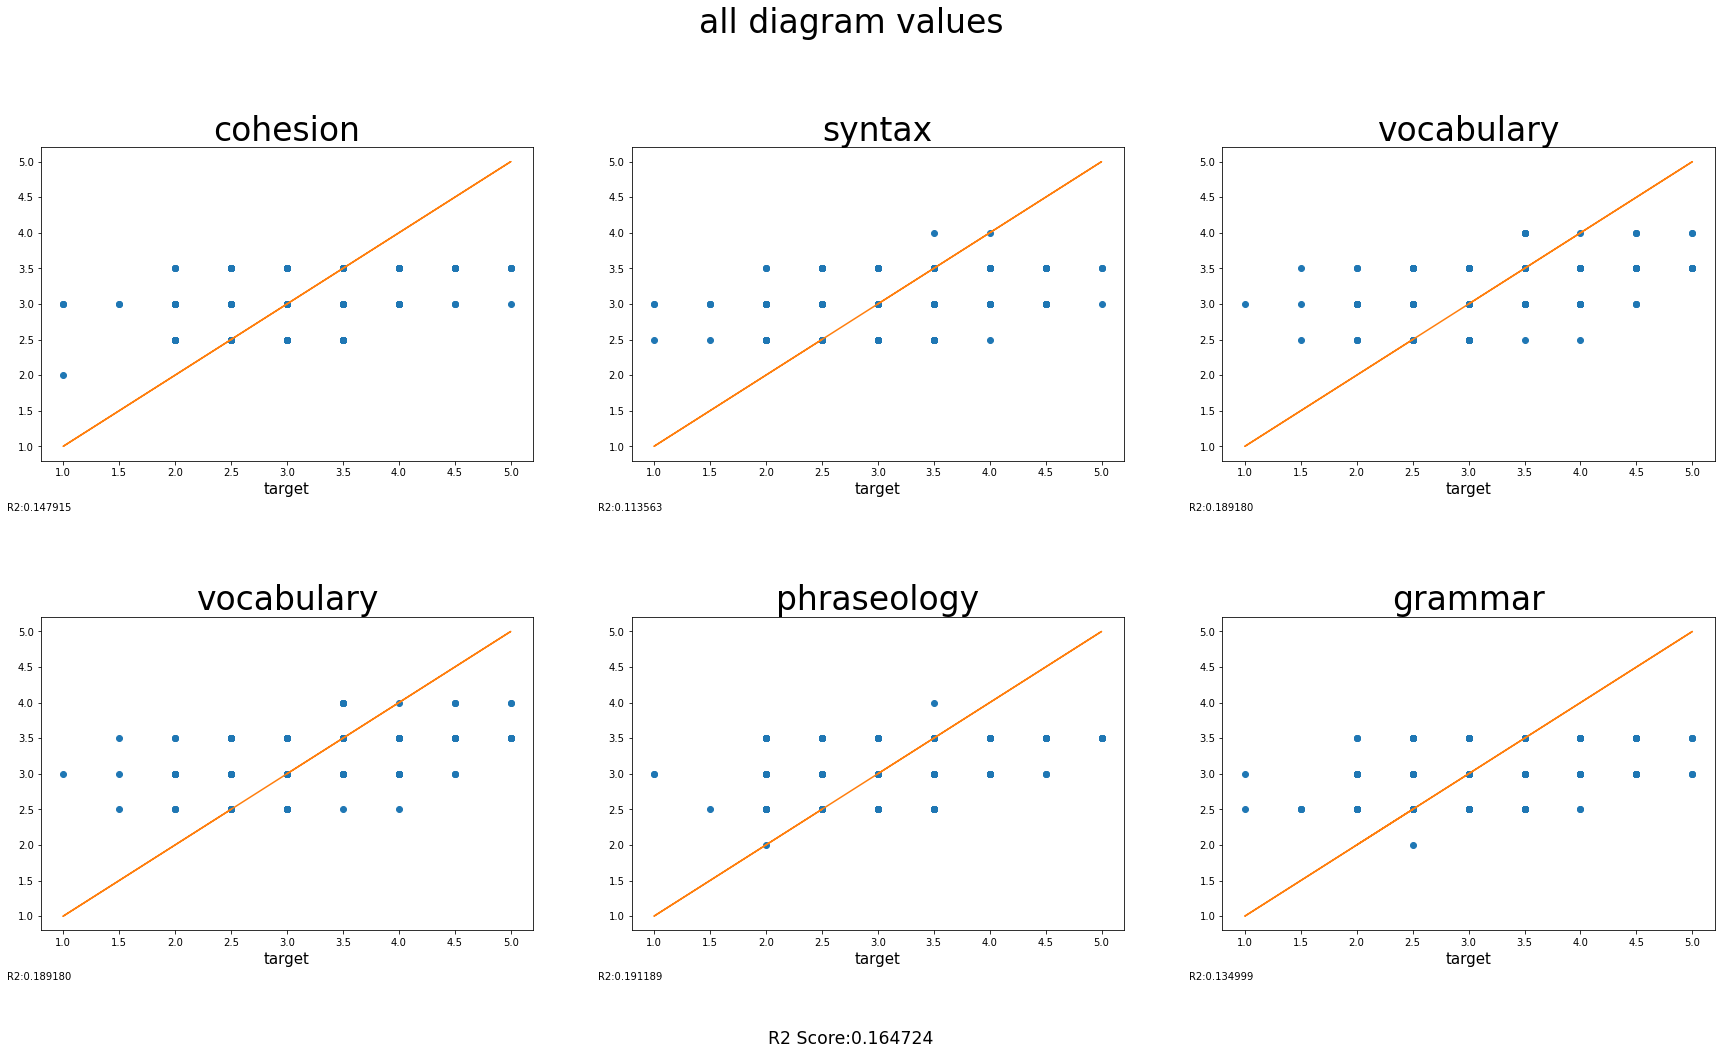

In [130]:
arrs=[
    (["Pred"] *6)+(["Real"] * 6),
    target_names.copy() + target_names.copy()
]  
scaler=StandardScaler()
tarrs=zip(arrs[0],arrs[1])
predictions_index=pd.MultiIndex.from_tuples(tarrs) 
pred_and_y=np.concatenate((predictions_sample,y_sample.to_numpy()),axis=1)
compares=pd.DataFrame(pred_and_y,columns=predictions_index) 
fig,ax =plt.subplots(2,3) 
fig.suptitle("all diagram values",size=33)   
fig.set_figwidth(30)
fig.set_figheight(15)
dimX=ax.shape[0] 
dimY=ax.shape[1]   
r2=r2_score(y_sample,predictions_sample,multioutput='uniform_average')  
ir2=r2_score(y_sample,predictions_sample,multioutput='raw_values') 
fig.text(0.5,0.02,"R2 Score:%f"%r2,fontsize="xx-large",ha='center')
for i in range(dimX): 
    for j in range(dimY) : 
        oneDIndex=(i*dimX)+j
        ax[i,j].plot(compares['Real'][target_names[oneDIndex]],compares['Pred'][target_names[oneDIndex]],"o")  
        ax[i,j].set_title(target_names[oneDIndex],size=33) 
        ax[i,j].set_xlabel("target",size=15) 
        m,b=np.polyfit(y_sample[target_names[oneDIndex]],y_sample[target_names[oneDIndex]],deg=1)
        ax[i,j].plot(y_sample[target_names[oneDIndex]],m*y_sample[target_names[oneDIndex]]+b)
        ax[i,j].text(x=0.5,y=-0.1,s="R2:%f" % ir2[oneDIndex])
fig.align_labels() 
fig.subplots_adjust(top=0.85,hspace=0.5)  

#### THEN WITH CLASSIFICATION JUST FOR BETTER VIZUALIZATION

In [85]:
predictions_classifier=[] 
for multiarr in predictions_sample: 
    subaux=[]
    for pred in multiarr:
        subaux.append(str(pred)) 
    predictions_classifier.append(subaux) 
predictions_classifier 
y_classifier=[]
for multiarr in y_sample.to_numpy(): 
    subaux=[] 
    for pred in multiarr:
        subaux.append(str(pred)) 
    y_classifier.append(subaux)  
y_classifier

[['2.5', '3.0', '3.0', '3.0', '2.0', '2.5'],
 ['3.0', '3.0', '3.5', '3.5', '4.0', '3.0'],
 ['5.0', '4.0', '4.5', '4.5', '4.0', '4.0'],
 ['2.5', '2.0', '3.0', '2.0', '2.0', '2.0'],
 ['3.5', '3.5', '3.5', '3.5', '3.5', '4.0'],
 ['2.0', '2.0', '2.5', '2.0', '2.0', '2.0'],
 ['3.5', '3.0', '3.0', '3.0', '3.5', '3.0'],
 ['3.5', '3.0', '2.5', '3.0', '2.0', '3.0'],
 ['3.0', '2.5', '3.0', '3.0', '2.0', '3.0'],
 ['3.5', '3.5', '3.5', '4.0', '4.0', '2.5'],
 ['3.0', '3.0', '4.0', '3.5', '4.0', '4.0'],
 ['3.5', '3.0', '3.0', '3.5', '2.5', '2.5'],
 ['3.0', '2.5', '2.5', '2.5', '2.0', '3.0'],
 ['3.0', '2.5', '3.0', '3.0', '2.0', '2.5'],
 ['4.0', '4.0', '3.5', '3.5', '3.0', '3.5'],
 ['3.0', '3.0', '3.0', '3.5', '4.0', '3.5'],
 ['3.5', '4.0', '4.0', '3.5', '4.0', '3.5'],
 ['2.0', '1.5', '2.0', '2.0', '1.5', '1.5'],
 ['2.0', '2.0', '2.5', '2.0', '2.0', '2.0'],
 ['2.5', '3.0', '3.5', '3.0', '3.0', '2.5'],
 ['3.5', '2.5', '3.0', '3.0', '2.5', '3.5'],
 ['3.0', '2.5', '3.5', '3.5', '3.0', '3.0'],
 ['3.5', '

In [101]:
labels=np.array([ 
    np.unique(y_classifier) ,
    np.unique(y_classifier) 
] )
labels

array([['1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0'],
       ['1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0']],
      dtype='<U3')

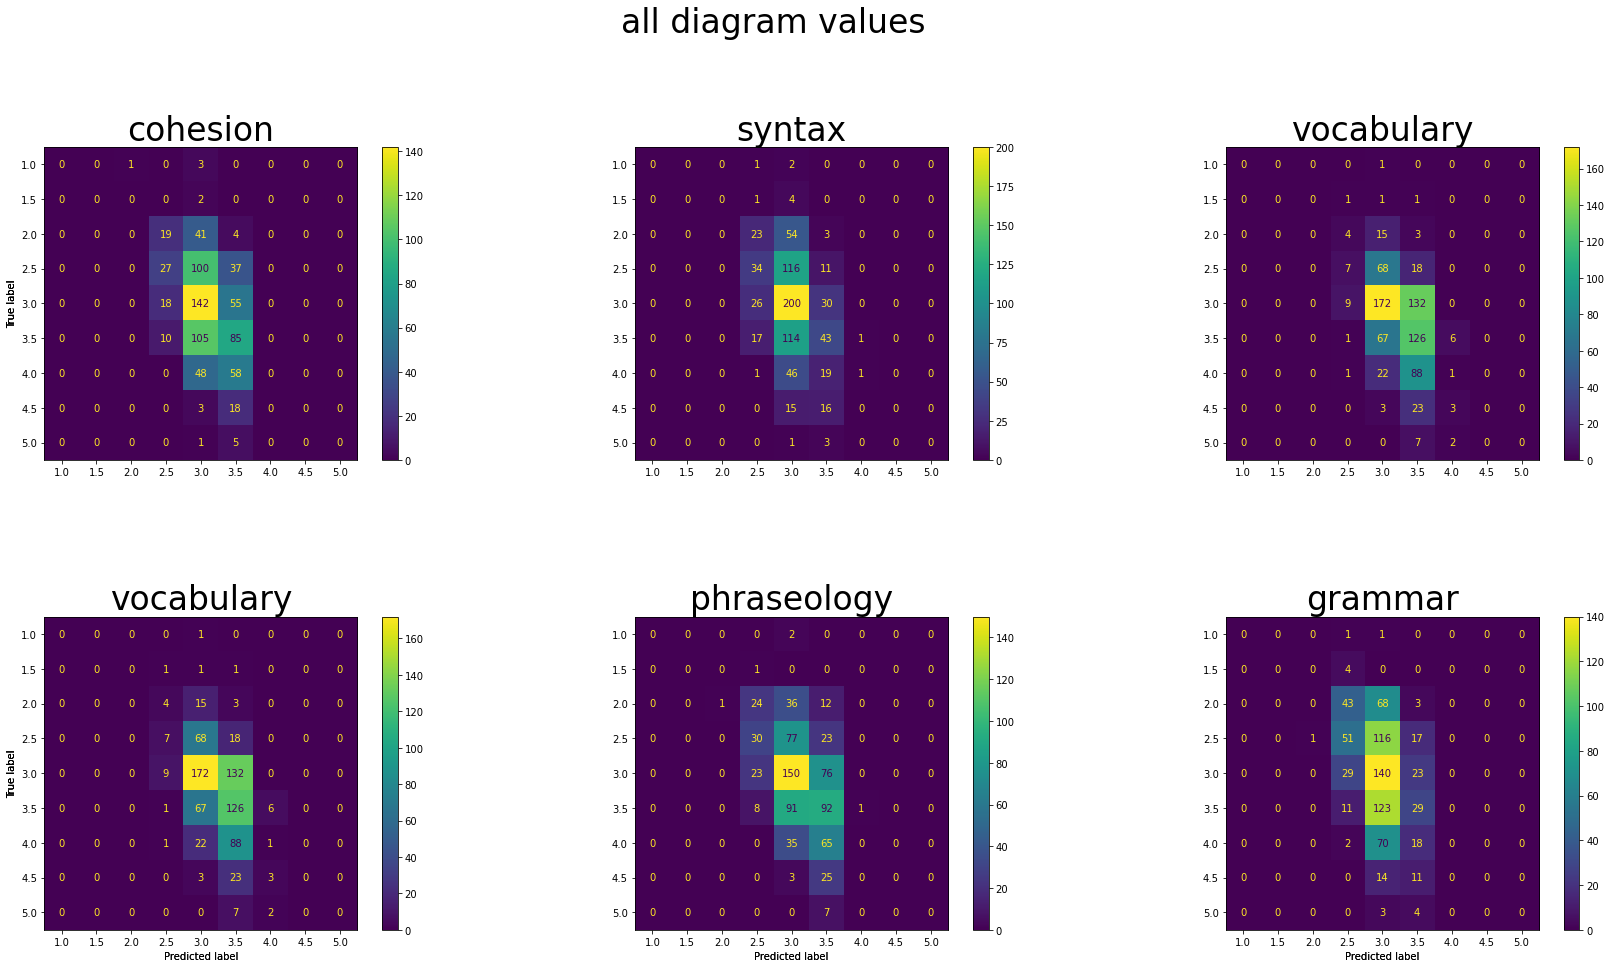

In [114]:
arrs=[
    (["Pred"] *6)+(["Real"] * 6),
    target_names.copy() + target_names.copy()
]  
scaler=StandardScaler()
tarrs=zip(arrs[0],arrs[1])
predictions_index=pd.MultiIndex.from_tuples(tarrs) 
pred_and_y=np.concatenate((predictions_classifier,y_classifier),axis=1)
compares=pd.DataFrame(pred_and_y,columns=predictions_index) 
fig,ax =plt.subplots(2,3) 
fig.suptitle("all diagram values",size=33)   
fig.set_figwidth(30)
fig.set_figheight(15)
dimX=ax.shape[0] 
dimY=ax.shape[1]   
for i in range(dimX): 
    for j in range(dimY) : 
        oneDIndex=(i*dimX)+j 
        cm=confusion_matrix(compares['Real'][target_names[oneDIndex]],compares['Pred'][target_names[oneDIndex]])
        ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax[i,j])
        ax[i,j].set_title(target_names[oneDIndex],size=33) 
        ax[i,j].set_xticks(np.arange(9),labels=np.unique(y_classifier)) 
        ax[i,j].set_yticks(np.arange(9),labels=np.unique(y_classifier)) 
        #ax[i,j].set_xbound(lower=0,upper=350)  
        #centerish=ax[i,j].get_xbound()[1]/2
        #centerishY=ax[i,j].get_ybound()[1]/2
        #ax[i,j].text(x=centerish-13,y=-centerishY/2.5,s=("R2:%f" % float(auxdic[oneDIndex][1])),ma="center")
fig.align_labels() 
fig.subplots_adjust(top=0.85,hspace=0.5) 

## VISUALIZING DATA 

### SEEING REGULAR WORD CLOUD

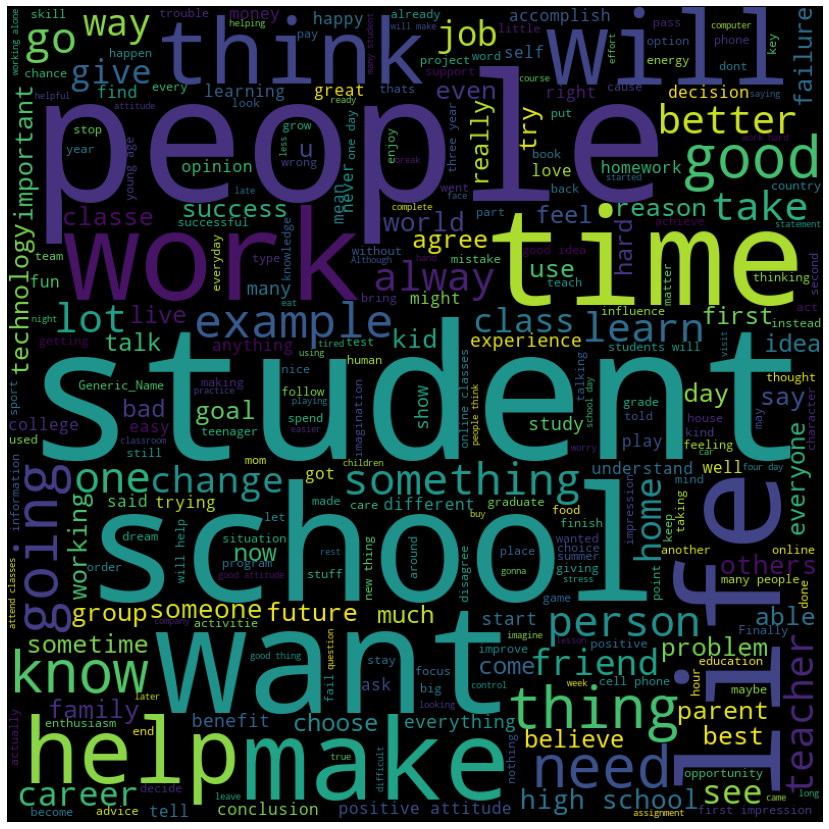

In [23]:
makeWordcloud(essays) 

### SEEING WORDCLOUD OF RADICALS

In [24]:
#radicals=getradicals(essays)

In [25]:
#makeWordcloud(" ".join(radicals)) 

### SEEING MOST COMMON WORDS FREQUENCY

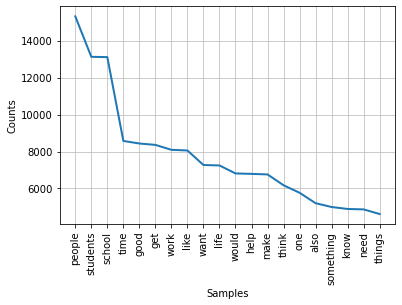

In [26]:
filtered_words=filter_text(essays,unique_words=False) 
common=FreqDist(filtered_words)
common.plot(20) 
plt.show()

### SEEING HISTOGRAM OF EACH TARGET

dimX:2 dimY:3
0
1
2
3
4
5


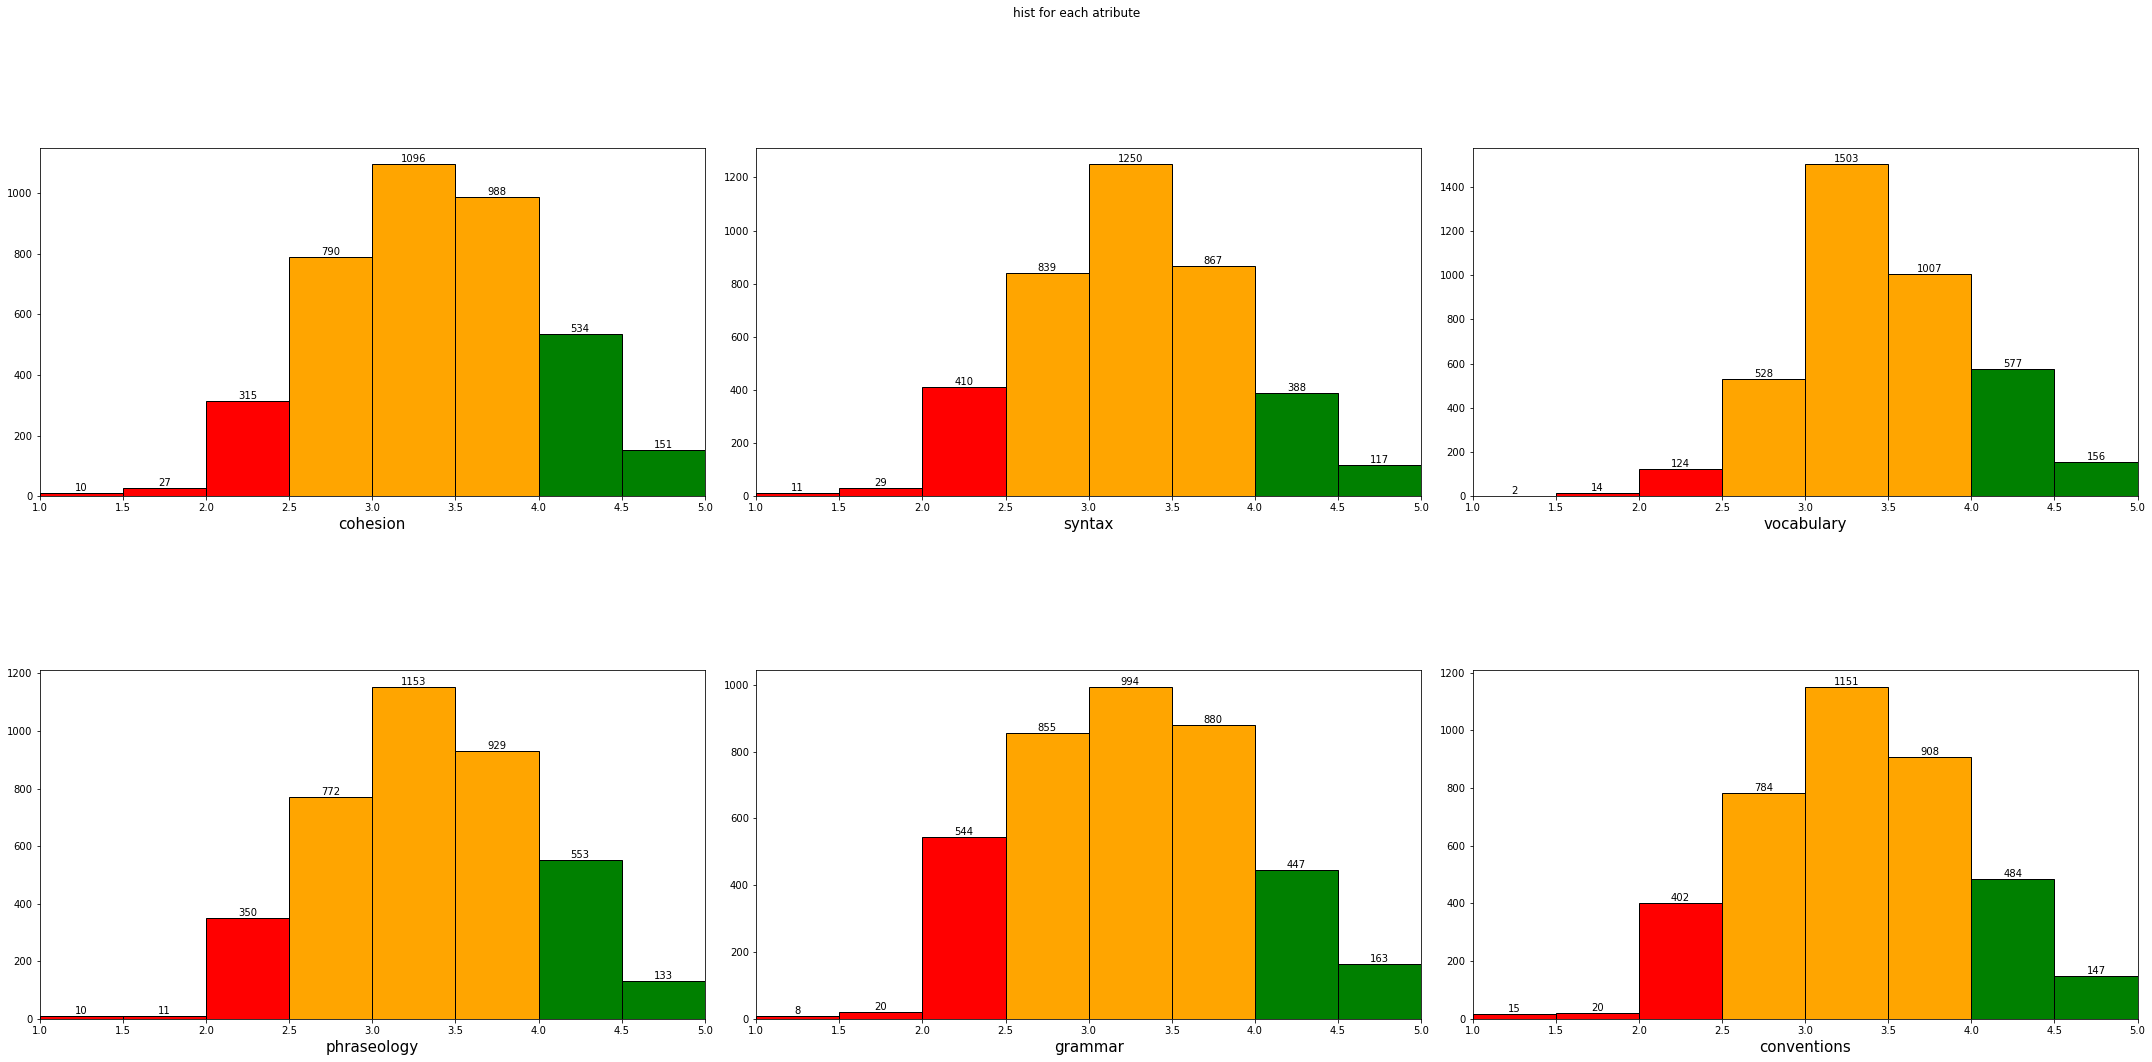

In [27]:

fig,ax =plt.subplots(2,3) 
fig.suptitle("hist for each atribute")   
fig.set_figwidth(30)
fig.set_figheight(15)
dimX=ax.shape[0] 
dimY=ax.shape[1]     
print("dimX:%d dimY:%d" % (dimX,dimY))
for i in range(dimX): 
    for j in range(dimY) : 
        oneDIndex=(i*dimY)+j 
        print(oneDIndex)
        N, bins, patches=ax[i,j].hist(y[target_names[oneDIndex]],edgecolor="black",bins=8)   
        for k in range(0,3):
            patches[k].set_facecolor("red") 
        for k in range(3,6): 
            patches[k].set_facecolor("orange")
        for k in range(6,len(patches)):  
            patches[k].set_facecolor("green")
        ax[i,j].bar_label(patches)
        ax[i,j].set_xlabel(target_names[oneDIndex],size=15)  
        ax[i,j].set_xbound(lower=1.0,upper=5.0)
fig.align_labels() 
fig.tight_layout()
fig.subplots_adjust(top=0.85,hspace=0.5)  

### MAKING HIST OF MISTAKES

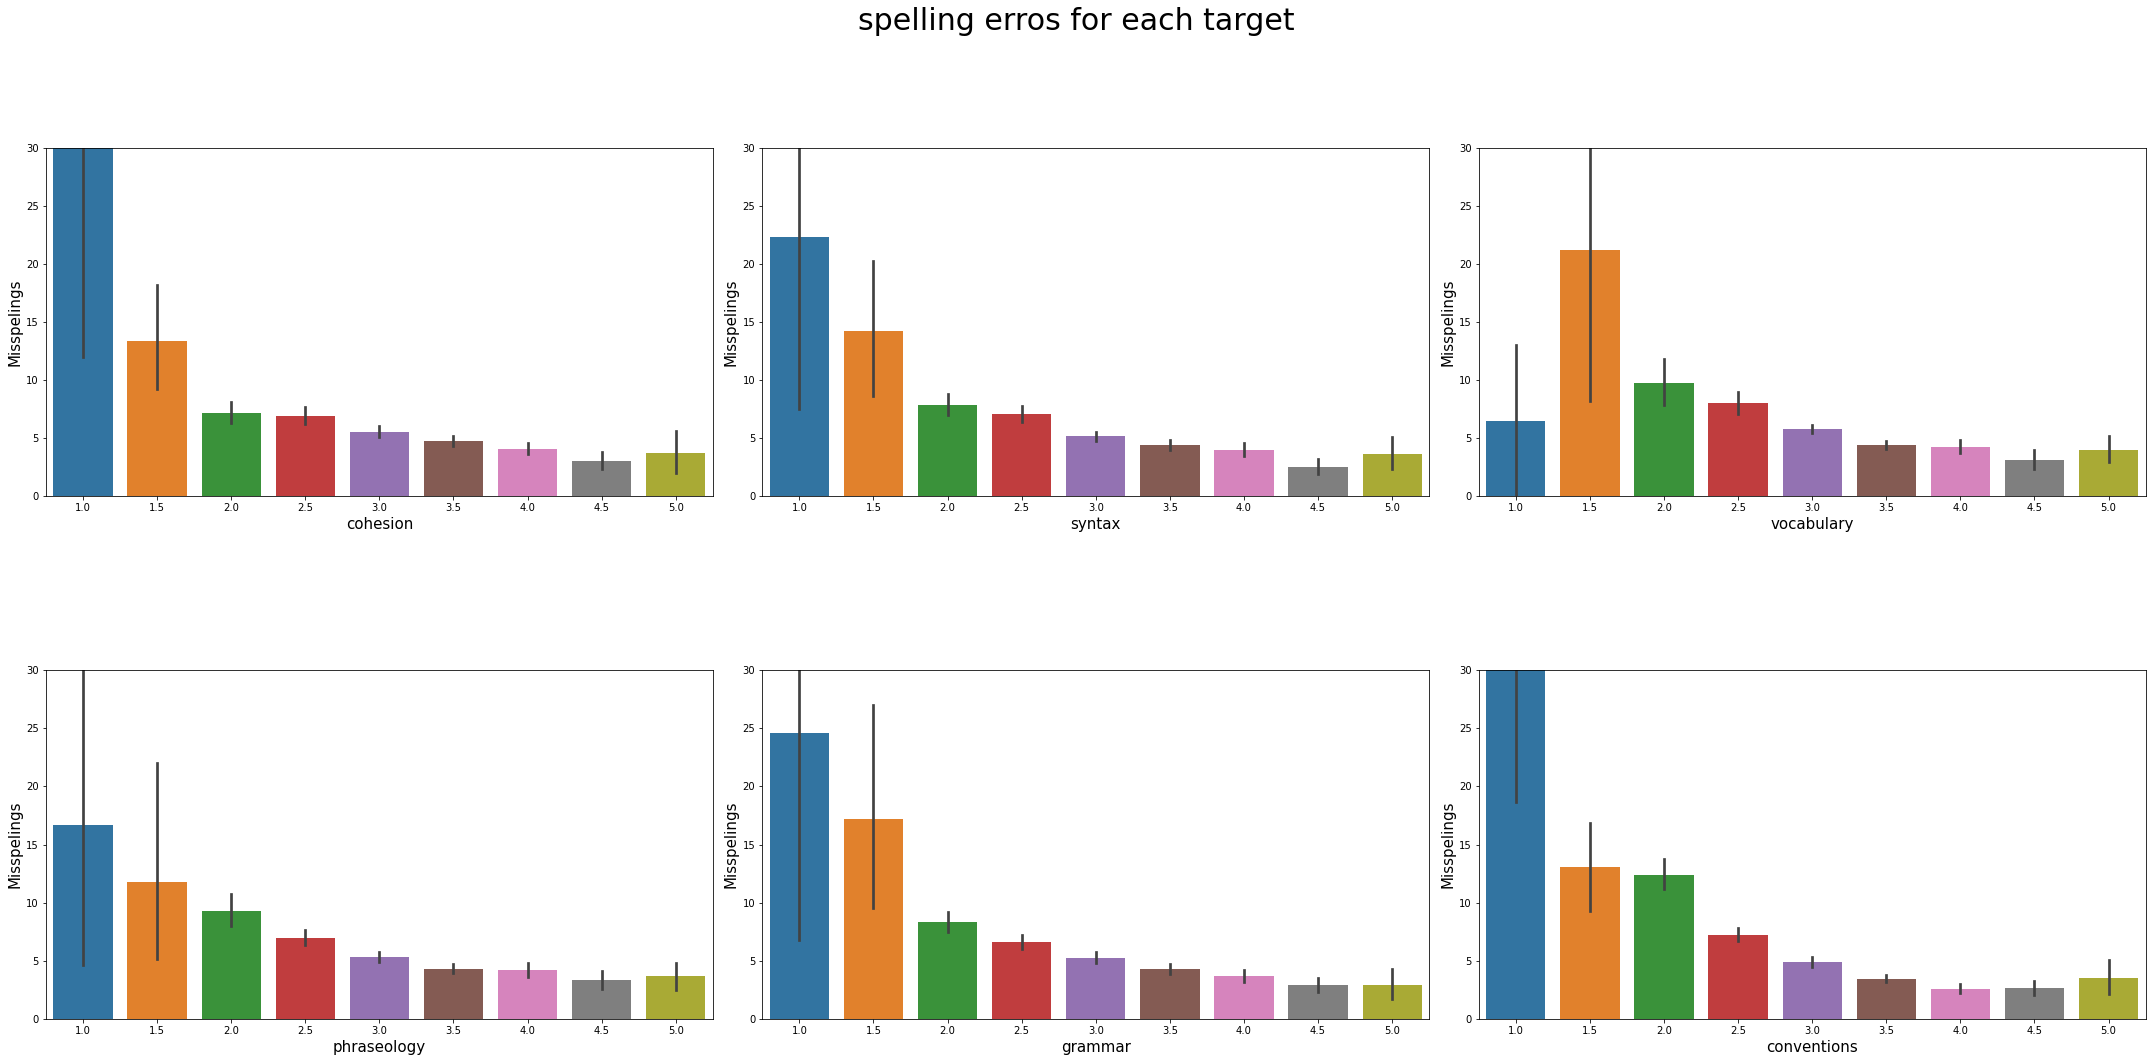

In [28]:
fig,ax =plt.subplots(2,3) 
fig.suptitle("spelling erros for each target",fontsize=30)   
fig.set_figwidth(30)
fig.set_figheight(15)
dimX=ax.shape[0] 
dimY=ax.shape[1]    
target_names=list(y)
for i in range(dimX): 
    for j in range(dimY) : 
        oneDIndex=(i*dimY)+j
        graph=sns.barplot(data=df_relevant,x=target_names[oneDIndex],y="ort_mistakes",ax=ax[i,j])
        ax[i,j].set_xlabel(target_names[oneDIndex],size=15) 
        ax[i,j].set_ylabel("Misspelings",size=15) 
        ax[i,j].set_ylim(0,30)
fig.align_labels() 
fig.tight_layout()
fig.subplots_adjust(top=0.85,hspace=0.5)  

#sns.barplot(data=df_relevant,x="grammar",y="ort_mistakes")

### MAKING HIST OF RADICALS

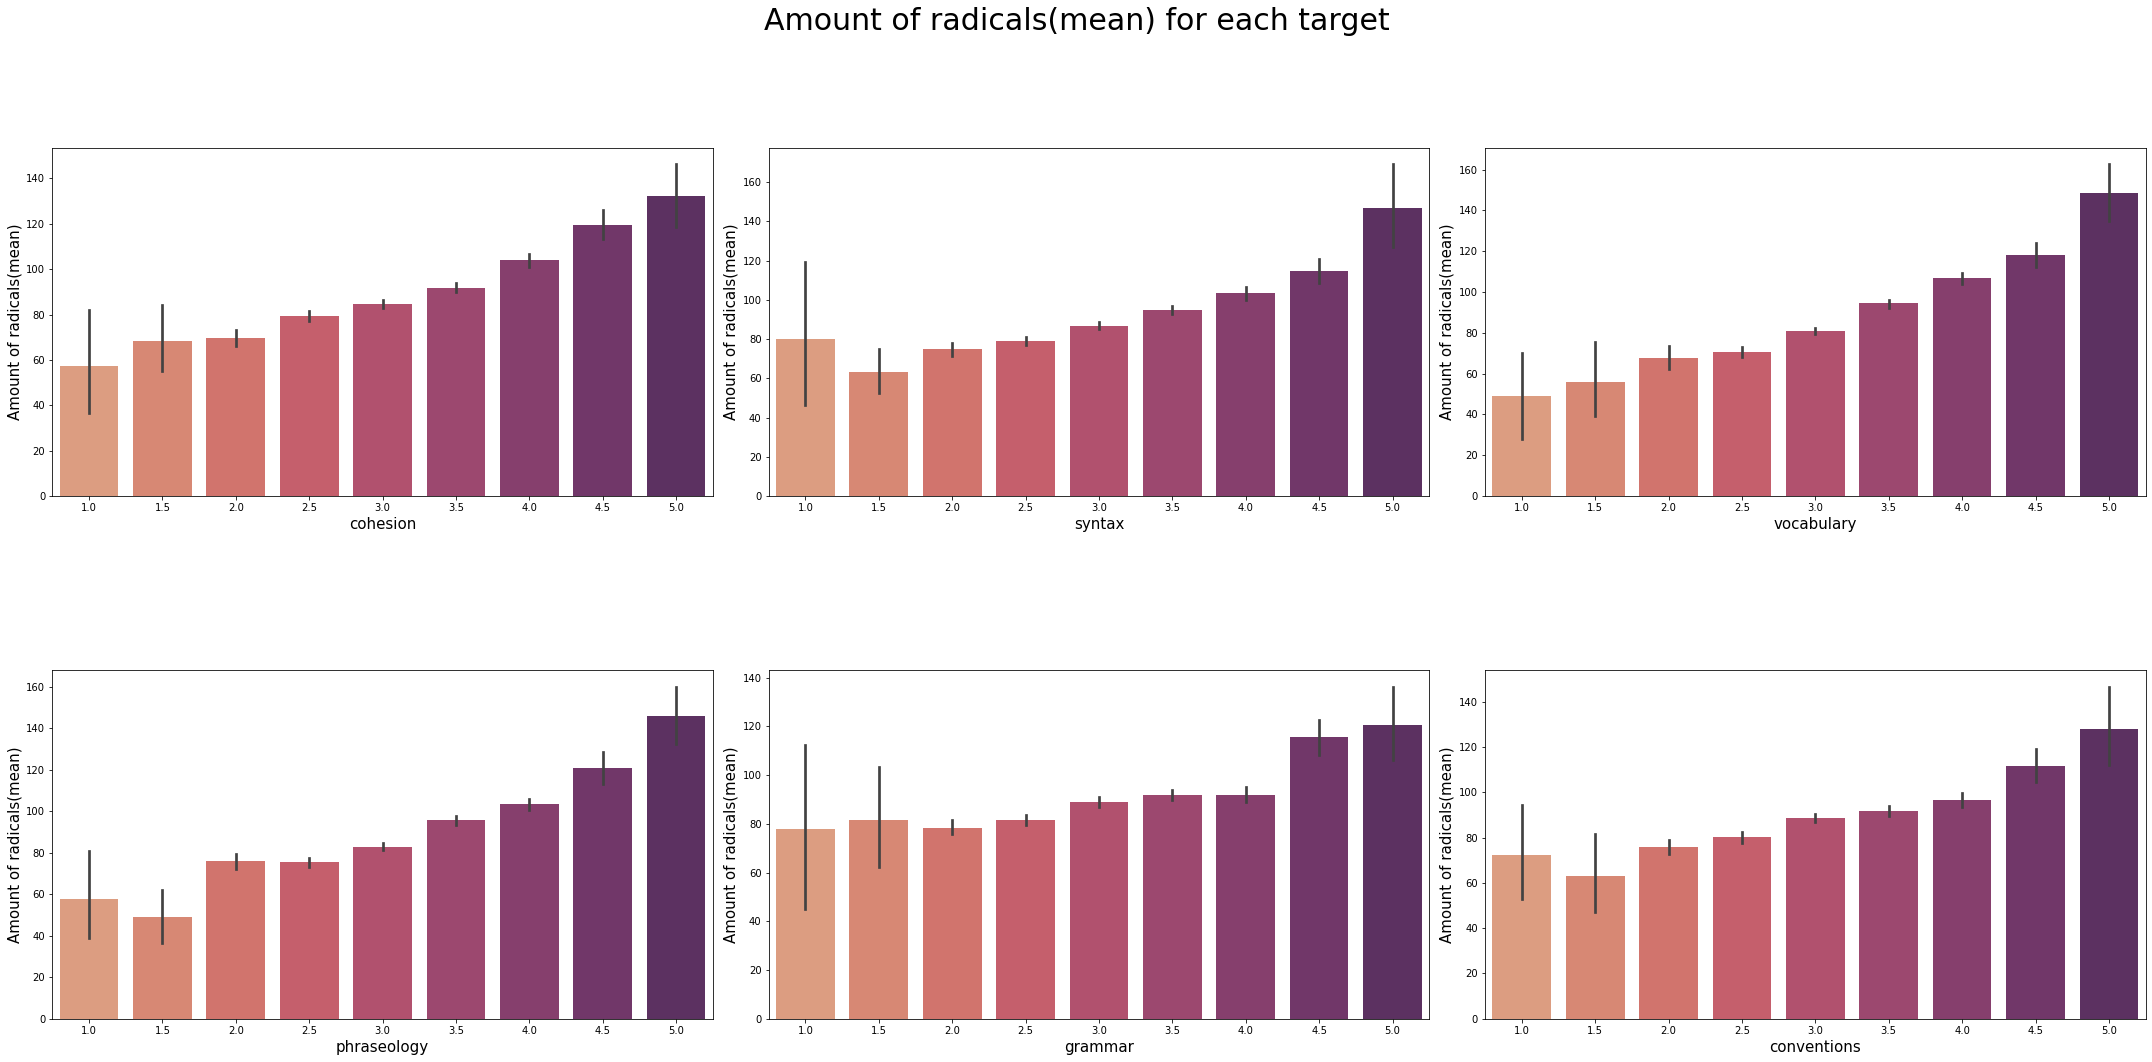

In [29]:
fig,ax =plt.subplots(2,3) 
fig.suptitle("Amount of radicals(mean) for each target",fontsize=30)   
fig.set_figwidth(30)
fig.set_figheight(15)
dimX=ax.shape[0] 
dimY=ax.shape[1]    
target_names=list(y)
for i in range(dimX): 
    for j in range(dimY) : 
        oneDIndex=(i*dimY)+j
        graph=sns.barplot(data=df_relevant,x=target_names[oneDIndex],y="amt_radicals",palette="flare",ax=ax[i,j])
        ax[i,j].set_xlabel(target_names[oneDIndex],size=15) 
        ax[i,j].set_ylabel("Amount of radicals(mean)",size=15) 
fig.align_labels() 
fig.tight_layout()
fig.subplots_adjust(top=0.85,hspace=0.5)  

### MAKING HIST OF AMOUNT OF WORDS

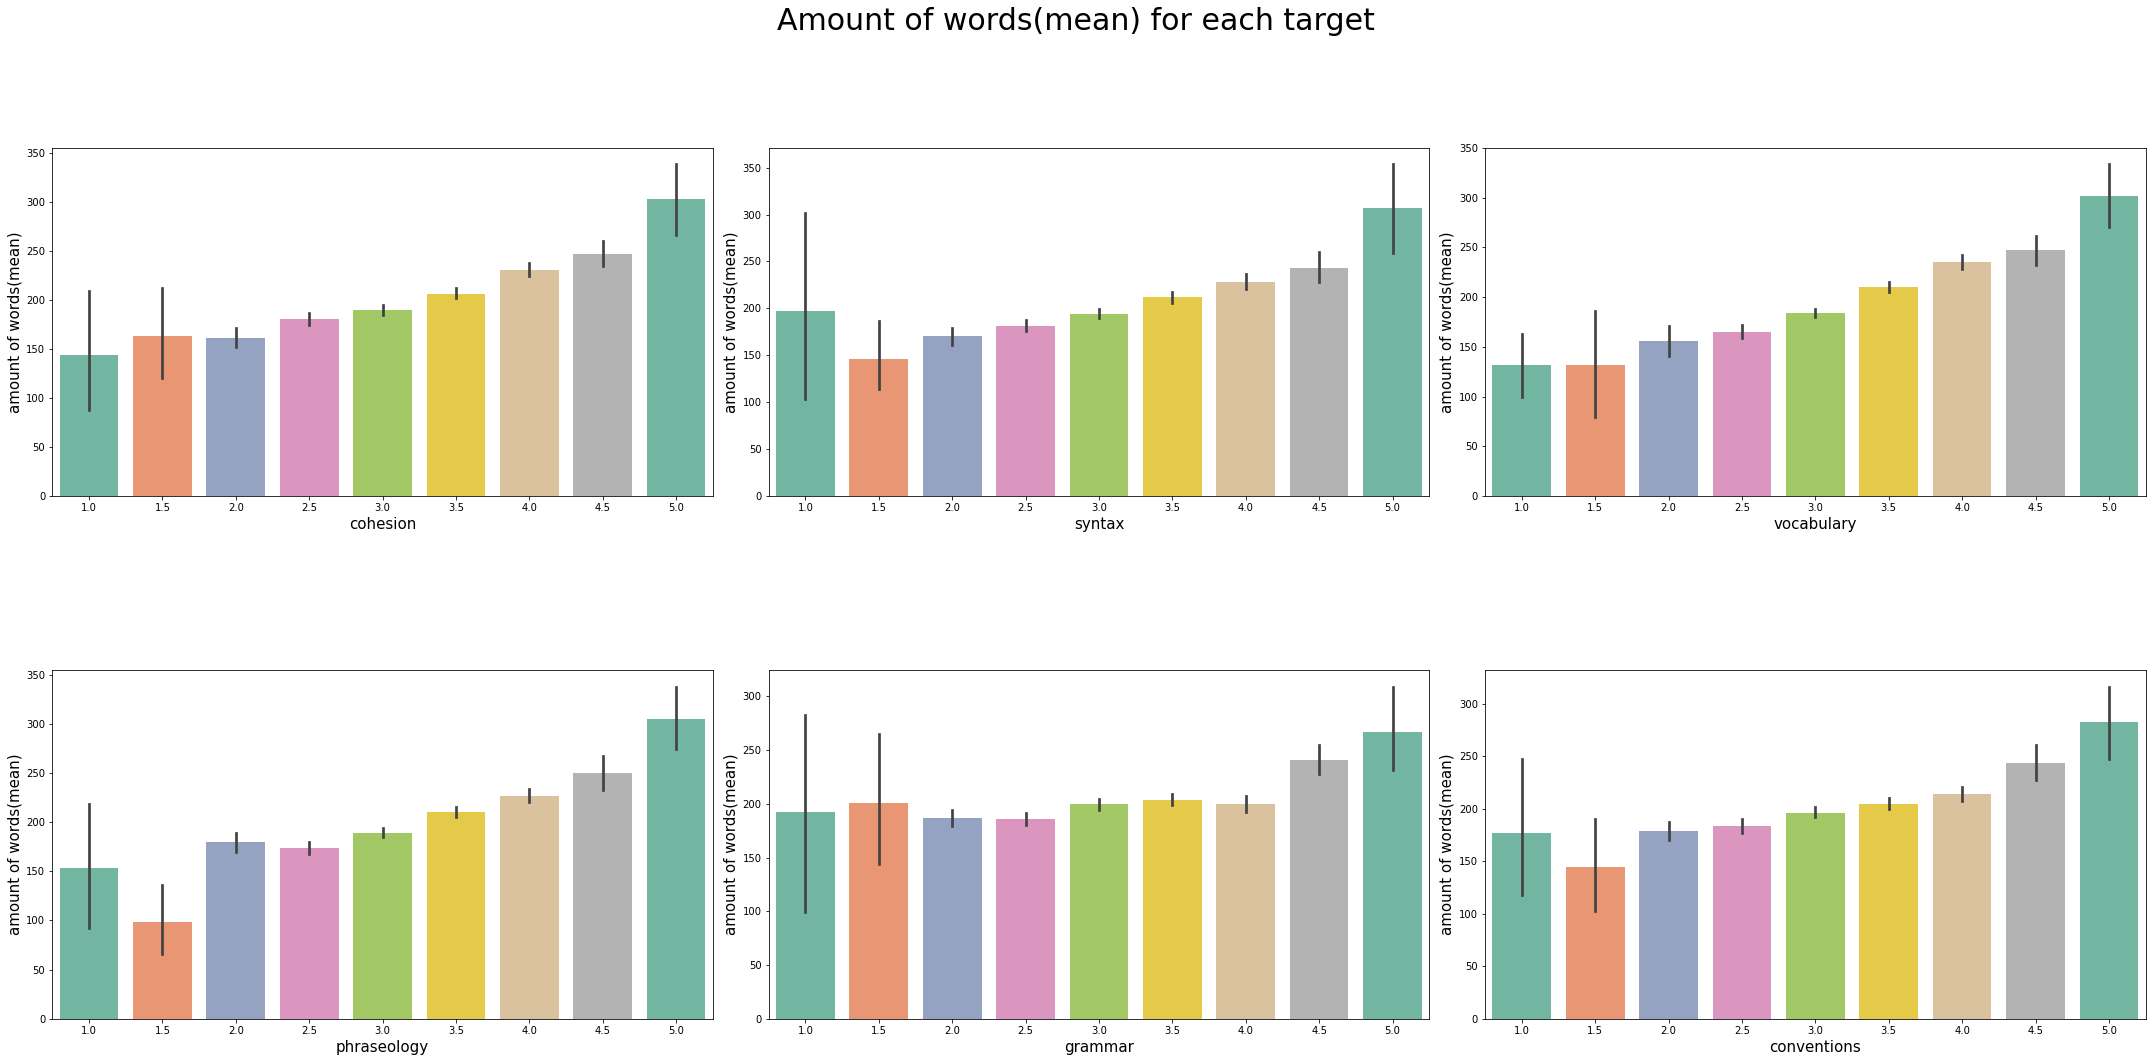

In [30]:
fig,ax =plt.subplots(2,3) 
fig.suptitle("Amount of words(mean) for each target",fontsize=30)   
fig.set_figwidth(30)
fig.set_figheight(15)
dimX=ax.shape[0] 
dimY=ax.shape[1]    
target_names=list(y)
for i in range(dimX): 
    for j in range(dimY) : 
        oneDIndex=(i*dimY)+j
        graph=sns.barplot(data=df_relevant,x=target_names[oneDIndex],y="n_of_words",palette="Set2",ax=ax[i,j])
        ax[i,j].set_xlabel(target_names[oneDIndex],size=15) 
        ax[i,j].set_ylabel("amount of words(mean)",size=15) 
fig.align_labels() 
fig.tight_layout()
fig.subplots_adjust(top=0.85,hspace=0.5)  

### MAKING HIST OF AMOUNT OF STOPWORDS

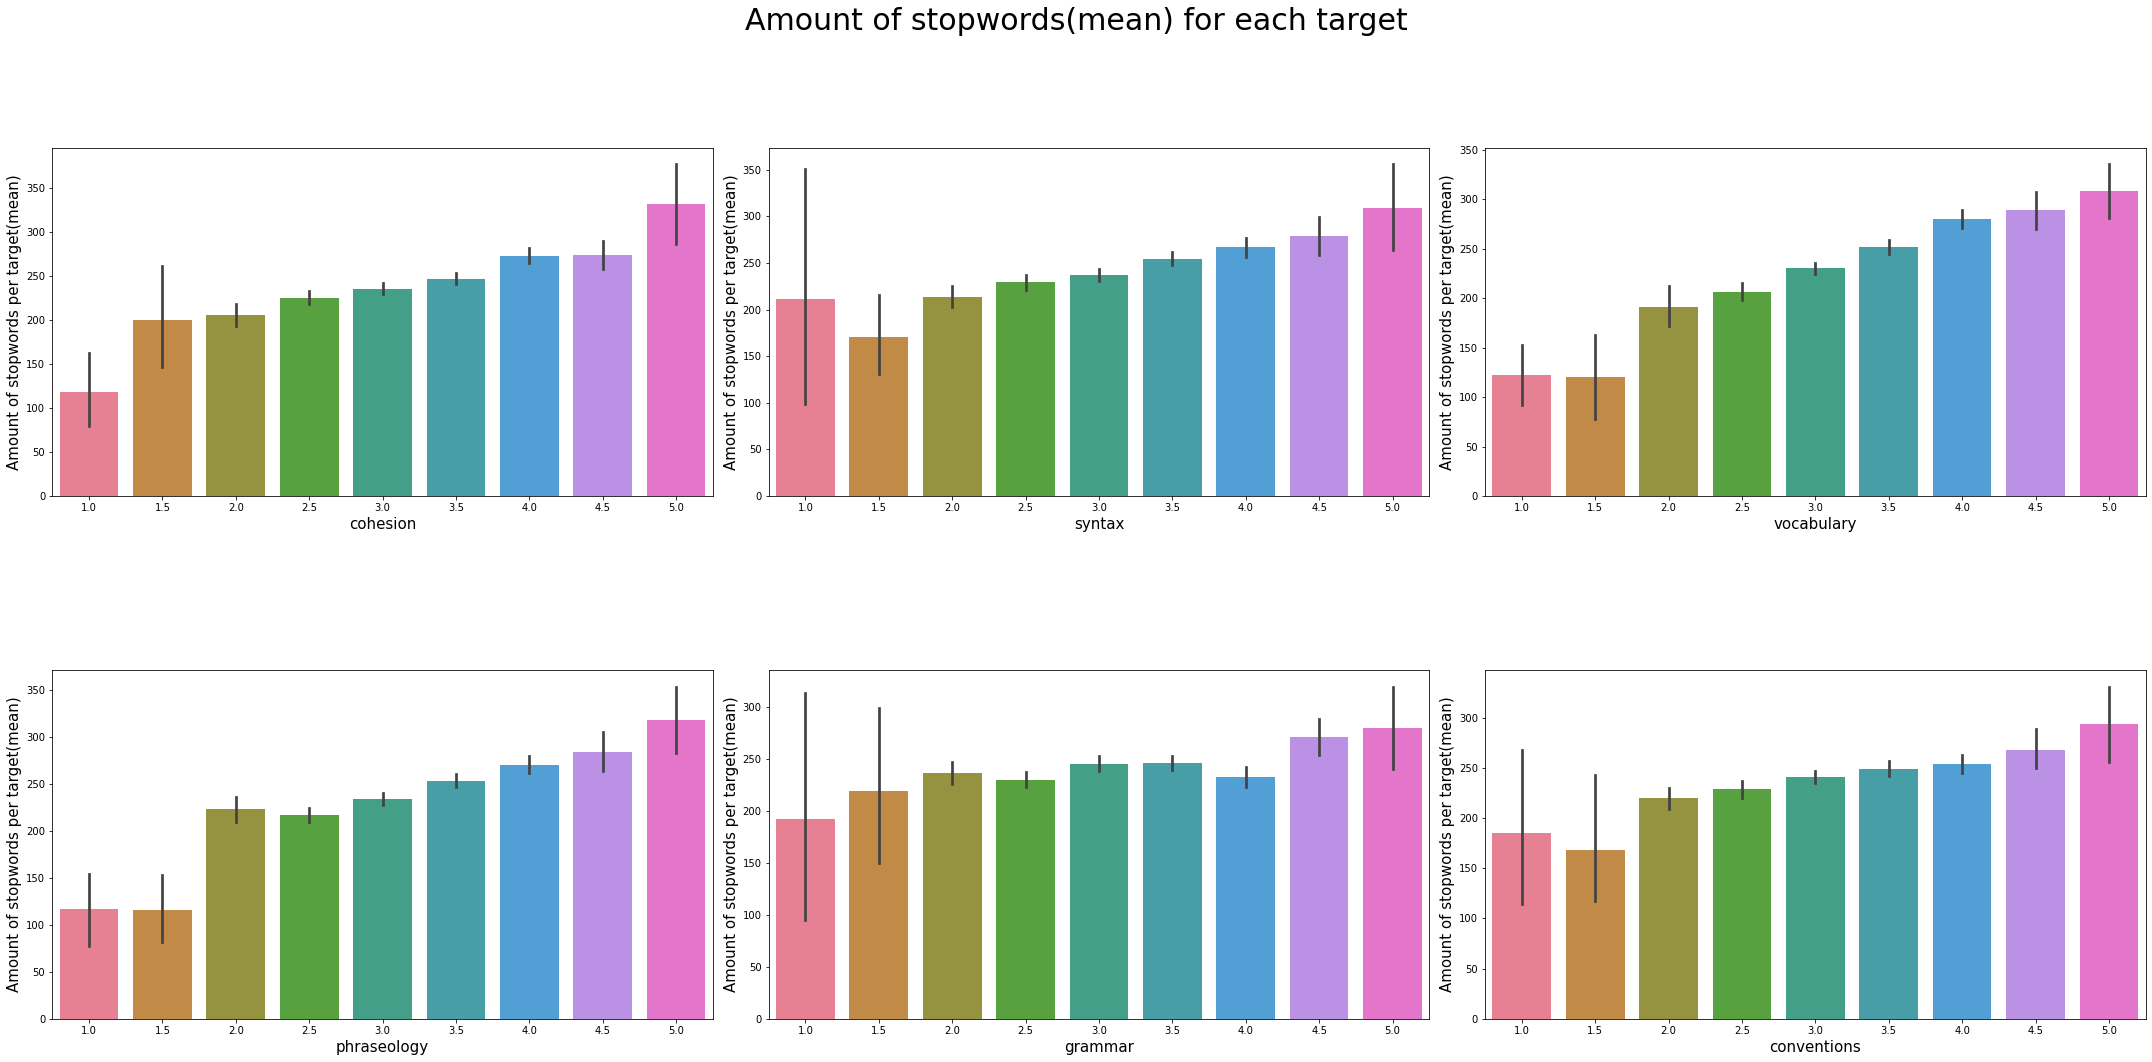

In [31]:
fig,ax =plt.subplots(2,3) 
fig.suptitle("Amount of stopwords(mean) for each target",fontsize=30)   
fig.set_figwidth(30)
fig.set_figheight(15)
dimX=ax.shape[0] 
dimY=ax.shape[1]    
target_names=list(y)
for i in range(dimX): 
    for j in range(dimY) : 
        oneDIndex=(i*dimY)+j
        graph=sns.barplot(data=df_relevant,x=target_names[oneDIndex],y="amt_stopwords",palette="husl",ax=ax[i,j])
        ax[i,j].set_xlabel(target_names[oneDIndex],size=15) 
        ax[i,j].set_ylabel("Amount of stopwords per target(mean)",size=15) 
fig.align_labels() 
fig.tight_layout()
fig.subplots_adjust(top=0.85,hspace=0.5)

## SAVING RELEVANT FILE TO CSV

In [32]:
df_relevant.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions,n_of_words,ort_mistakes,amt_radicals,amt_stopwords
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053,197.701867,5.582204,88.028893,240.545641
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450,86.542751,8.247720,34.454573,113.835489
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,0.000000,6.000000,6.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000,135.000000,0.000000,62.000000,161.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,185.000000,2.000000,83.000000,220.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,244.000000,8.000000,107.000000,295.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,579.000000,136.000000,255.000000,853.000000


In [33]:
df_relevant 

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,n_of_words,most_common_words,ort_mistakes,amt_radicals,amt_stopwords
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,129,"('students', 'go', 'home', 'u', 'wont', 'get',...",1,81,135
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,215,"('change', 'different', 'see', 'understand', '...",0,80,323
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,133,"('average', 'sports', 'school', 'activities', ...",0,56,202
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,282,"('make', 'choices', 'others', 'want', 'people'...",0,125,484
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,112,"('people', 'act', 'change', 'kindess', 'person...",10,58,122
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5,96,"('believe', 'could', 'using', 'cellphones', 'u...",16,56,83
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0,214,"('students', 'work', 'group', 'working', 'get'...",15,98,253
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0,109,"('problem', 'best', 'every', 'get', 'chance', ...",9,59,150
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5,228,"('people', 'others', 'example', 'influence', '...",1,94,294


In [34]:
#df_relevant.to_csv("./newcsvs/relevant.csv",index=False) 
e_string=df_relevant["full_text"][1540] 
df_relevant.iloc[2389] 

text_id                                                   B1AFACE6704E
full_text            I agree with Michelangelo's statement as I hav...
cohesion                                                           5.0
syntax                                                             5.0
vocabulary                                                         5.0
phraseology                                                        5.0
grammar                                                            5.0
conventions                                                        5.0
n_of_words                                                         457
most_common_words    ('high', 'setting', 'goals', 'aim', 'goal', 'c...
ort_mistakes                                                         4
amt_radicals                                                       155
amt_stopwords                                                      466
Name: 2389, dtype: object

## APPLYING DATA ARGUMENTATION TO DATASET

## EMBEDDING TEXT

### choosing embedder

In [116]:
def embedder(text) :
    return {
    "bag_of_words":transform_to_bag_of_words(text), 
    "tfidf":transform_to_tfidf(text)
    }

### little test

In [117]:
text="leo was great till that hapenned and then some machine student people hello there you obi-wan anime"  
text2="""We're no strangers to love
You know the rules and so do I (do I)
A full commitment's what I'm thinking of
You wouldn't get this from any other guy
I just wanna tell you how I'm feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
We've known each other for so long
Your heart's been aching, but you're too shy to say it (say it)
Inside, we both know what's been going on (going on)
We know the game and we're gonna play it
And if you ask me how I'm feeling
Don't tell me you're too blind to see
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
We've known each other for so long
Your heart's been aching, but you're too shy to say it (to say it)
Inside, we both know what's been going on (going on)
We know the game and we're gonna play it
I just wanna tell you how I'm feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you""" 
tlist=[text,text2]
temb=embedder(tlist)
bag,colnames=temb["bag_of_words"]
pd.DataFrame(bag,columns=colnames)

,aching,anime,around,ask,blind,commitment,cry,desert,feeling,full,...,see,shy,strangers,student,ta,tell,thinking,till,understand,wan
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
1,2,0,6,1,1,1,6,6,3,1,...,1,2,1,0,2,9,1,0,2,2


### start embedding

In [118]:
X=df_relevant.drop(columns=target_names)
X=X.set_index("text_id")   
temb=embedder(X)
X,colnames=temb["tfidf"]
colnames=np.concatenate((colnames,["n_of_words",'ort_mistakes','amt_radicals','amt_stopwords'])) 
X=pd.DataFrame(X,columns=colnames) 
X

,abandon,abandoned,abc,abilities,ability,able,abole,abot,aboute,abraham,...,youyou,ypu,yuo,zero,zone,zoo,n_of_words,ort_mistakes,amt_radicals,amt_stopwords
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,129.0,1.0,81.0,135.0
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,215.0,0.0,80.0,323.0
2,0.0,0.0,0.0,0.0,0.000000,0.090172,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,133.0,0.0,56.0,202.0
3,0.0,0.0,0.0,0.0,0.000000,0.025579,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,282.0,0.0,125.0,484.0
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,112.0,10.0,58.0,122.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3906,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,96.0,16.0,56.0,83.0
3907,0.0,0.0,0.0,0.0,0.000000,0.058975,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,214.0,15.0,98.0,253.0
3908,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,109.0,9.0,59.0,150.0
3909,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,228.0,1.0,94.0,294.0


## TRAINING MODEL

In [ ]:
df_relevant

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,n_of_words,most_common_words,ort_mistakes,amt_radicals,amt_stopwords
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,129,"('students', 'go', 'home', 'u', 'wont', 'get',...",1,81,135
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,215,"('change', 'different', 'see', 'understand', '...",0,80,323
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,133,"('average', 'sports', 'school', 'activities', ...",0,56,202
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,282,"('make', 'choices', 'others', 'want', 'people'...",0,125,484
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,112,"('people', 'act', 'change', 'kindess', 'person...",10,58,122
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5,96,"('believe', 'could', 'using', 'cellphones', 'u...",16,56,83
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0,214,"('students', 'work', 'group', 'working', 'get'...",15,98,253
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0,109,"('problem', 'best', 'every', 'get', 'chance', ...",9,59,150
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5,228,"('people', 'others', 'example', 'influence', '...",1,94,294


In [263]:
def getModels(): 
   return {"LINEAR REGRESSION":MultiOutputRegressor(LinearRegression()), 
    "RANDOM FOREST":MultiOutputRegressor(RandomForestRegressor(max_depth=100)),
    "ADA BOOST":MultiOutputRegressor(AdaBoostRegressor()), 
    "DECISION TREE":MultiOutputRegressor(DecisionTreeRegressor()), 
    "SGD":MultiOutputRegressor(make_pipeline(StandardScaler(),SGDRegressor(max_iter=1000, tol=1e-3))), 
    "KNN":MultiOutputRegressor(KNeighborsRegressor()),
    "RNN":MultiOutputRegressor(RadiusNeighborsRegressor()),
    "EXTRA TREES":MultiOutputRegressor(ExtraTreesRegressor(random_state=0,max_depth=6)),
    "GRADIENT BOOST":MultiOutputRegressor(GradientBoostingRegressor(random_state=0))}

In [ ]:
predictions= cross_val_predict(getModels()['RANDOM FOREST'],X,y,cv=10,n_jobs=6)

going to 'round' the predicitons to the values said in the competition[1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]

In [ ]:
aux=[]
for multiarr in predictions: 
    subaux=[]
    for pred in multiarr:
        subaux.append(padronizingpred(pred)) 
    aux.append(subaux) 

In [ ]:
predictions=aux

### displaying standard regression graph

In [ ]:
#predictions["target"]=y  
arrs=[
    (["Pred"] *6)+(["Real"] * 6),
    target_names.copy() + target_names.copy()
]  
scaler=StandardScaler()
tarrs=zip(arrs[0],arrs[1])
predictions_index=pd.MultiIndex.from_tuples(tarrs) 
pred_and_y=np.concatenate((predictions,y.to_numpy()),axis=1)
compares=pd.DataFrame(pred_and_y,columns=predictions_index) 
#print(predictions)
#predictions=np.transpose(pd.DataFrame(predictions)) 
fig,ax =plt.subplots(2,3) 
fig.suptitle("all diagram values",size=33)   
fig.set_figwidth(30)
fig.set_figheight(15)
dimX=ax.shape[0] 
dimY=ax.shape[1]   
r2=r2_score(y,predictions,multioutput='uniform_average') 
fig.text(0.5,0.02,"R2 Score:%f"%r2,fontsize="xx-large",ha='center')
for i in range(dimX): 
    for j in range(dimY) : 
        oneDIndex=(i*dimX)+j
        ax[i,j].plot(compares['Real'][target_names[oneDIndex]],compares['Pred'][target_names[oneDIndex]],"o",alpha=0.001)  
        ax[i,j].set_title(target_names[oneDIndex],size=33) 
        ax[i,j].set_xlabel("target",size=15) 
        #ax[i,j].set_xbound(lower=0,upper=350)  
        m,b=np.polyfit(y[target_names[oneDIndex]],y[target_names[oneDIndex]],deg=1)
        ax[i,j].plot(y[target_names[oneDIndex]],m*y[target_names[oneDIndex]]+b)
        #centerish=ax[i,j].get_xbound()[1]/2
        #centerishY=ax[i,j].get_ybound()[1]/2
        #ax[i,j].text(x=centerish-13,y=-centerishY/2.5,s=("R2:%f" % float(auxdic[oneDIndex][1])),ma="center")
fig.align_labels() 
fig.subplots_adjust(top=0.85,hspace=0.5) 

NameError: name 'predictions' is not defined

### transforming to classification for better visualization

In [ ]:
y_ohc=pd.get_dummies(y ,columns=target_names) 
y_ohc  
pred_ohc=pd.DataFrame(predictions,columns=target_names) 
pred_ohc

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,3.070,3.140,3.340,3.185,3.245,3.150
1,3.090,2.985,3.185,2.890,2.655,3.080
2,2.900,3.035,3.030,3.045,3.060,3.035
3,3.455,3.255,3.470,3.410,3.210,3.275
4,2.785,2.580,2.895,2.710,2.875,2.450
...,...,...,...,...,...,...
3906,2.615,2.425,2.580,2.585,2.690,2.345
3907,3.500,3.110,3.495,3.400,3.255,3.215
3908,2.860,2.655,2.875,2.730,2.900,2.485
3909,3.360,3.325,3.540,3.355,3.150,3.355


In [ ]:
compares

Pred                                                       Real  \
     cohesion syntax vocabulary phraseology grammar conventions cohesion   
0       3.070  3.140      3.340       3.185   3.245       3.150      3.5   
1       3.090  2.985      3.185       2.890   2.655       3.080      2.5   
2       2.900  3.035      3.030       3.045   3.060       3.035      3.0   
3       3.455  3.255      3.470       3.410   3.210       3.275      4.5   
4       2.785  2.580      2.895       2.710   2.875       2.450      2.5   
...       ...    ...        ...         ...     ...         ...      ...   
3906    2.615  2.425      2.580       2.585   2.690       2.345      2.5   
3907    3.500  3.110      3.495       3.400   3.255       3.215      4.0   
3908    2.860  2.655      2.875       2.730   2.900       2.485      2.5   
3909    3.360  3.325      3.540       3.355   3.150       3.355      4.0   
3910    3.320  3.055      3.405       3.560   3.115       3.255      3.5   

                                                        
     syntax vocabulary phraseology grammar conventions  
0       3.5        3.0         3.0     4.0         3.0  
1       2.5        3.0         2.0     2.0         2.5  
2       3.5        3.0         3.0     3.0         2.5  
3       4.5        4.5         4.5     4.0         5.0  
4       3.0        3.0         3.0     2.5         2.5  
...     ...        ...         ...     ...         ...  
3906    3.0        3.0         3.5     2.5         2.5  
3907    4.0        4.0         4.0     3.5         3.0  
3908    3.0        3.0         3.0     3.5         3.0  
3909    4.5        4.5         4.0     4.5         4.5  
3910    2.5        3.5         3.0     3.0         3.5  

[3911 rows x 12 columns]

## Running time

In [ ]:
end=time.time() 
print(end-start)

2060.737160921097
